In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# **Importation des bibliothèques**

In [60]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import  accuracy_score , confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import cv2

# **Load Data**

In [11]:
# Chemins des répertoires
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test"

In [20]:
# Directory containing the "Train" folder
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"

filepath =[]
label = []
folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [21]:
df_train

,filepath,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
5211,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5214,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [22]:
# Directory containing the "Train" folder
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [23]:
# Head 
df_test.sample(5)

,filepath,label
326,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
136,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
392,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
412,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
559,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [24]:
# Shape
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

The shape of The Train data is: (5216, 2)
The shape of The Test data is: (624, 2)


# **Making Train Test And Validation Datasets**

In [53]:
#Data_Dir
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

IMAGE_SIZE = (256,256)

print('Training Images:')
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

#Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.1,
     subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Training Images:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Validation Images:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


# **Encoding Labels**

In [28]:
# Extract labels
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

# Encode Labels

# Define your class labels
class_labels = ['NORMAL', 'PNEUMONIA'] 

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the class labels
label_encoder.fit(class_labels)

# Transform the labels for training dataset
train_labels_encoded = label_encoder.transform(train_labels)
# Transform the labels for validation dataset
validation_labels_encoded = label_encoder.transform(validation_labels)

# Transform the labels for test dataset
test_labels_encoded = label_encoder.transform(test_labels)
# Shape of the dataset
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


# **Visualizing Train Images**

In [15]:
# Paramètres
img_height, img_width = 224, 224
batch_size = 8
# Créer des générateurs de données avec augmentation pour l'entraînement et sans augmentation pour la validation et le test
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
# Charger MobileNetV2 pré-entraîné sans les couches supérieures
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)
# Congeler les couches du modèle de base
base_model.trainable = False

In [17]:
# Ajouter des couches de classification au modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# **Normalizing Pixel Value**

In [42]:
# Normalizing Pixel Values 

# Train Data 
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
# Val Data
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
# Test Data
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# **Visual Count of Train Label**

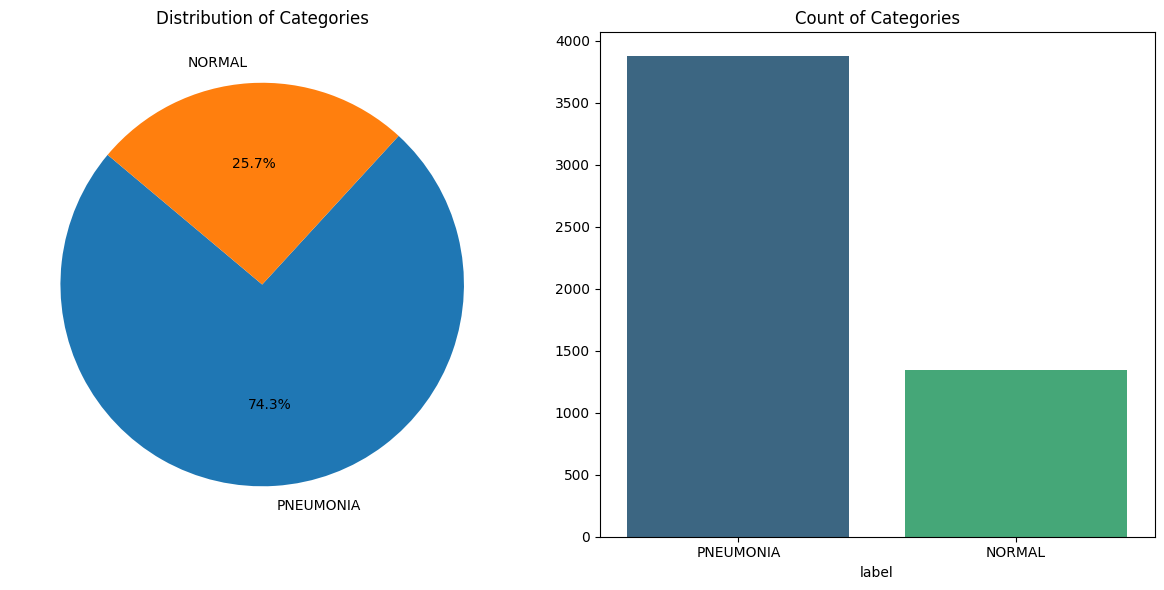

In [32]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# **Visual Count of Test Label**

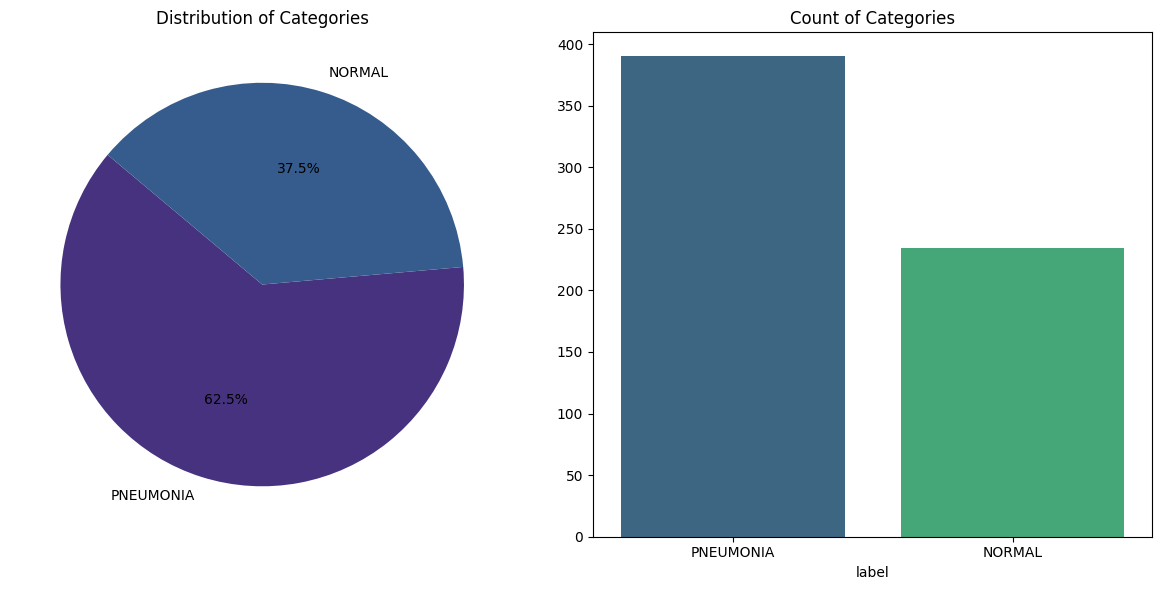

In [33]:
# Count the occurrences of each category in the 'category' column
count = df_test['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# **Visualizing Train Images**

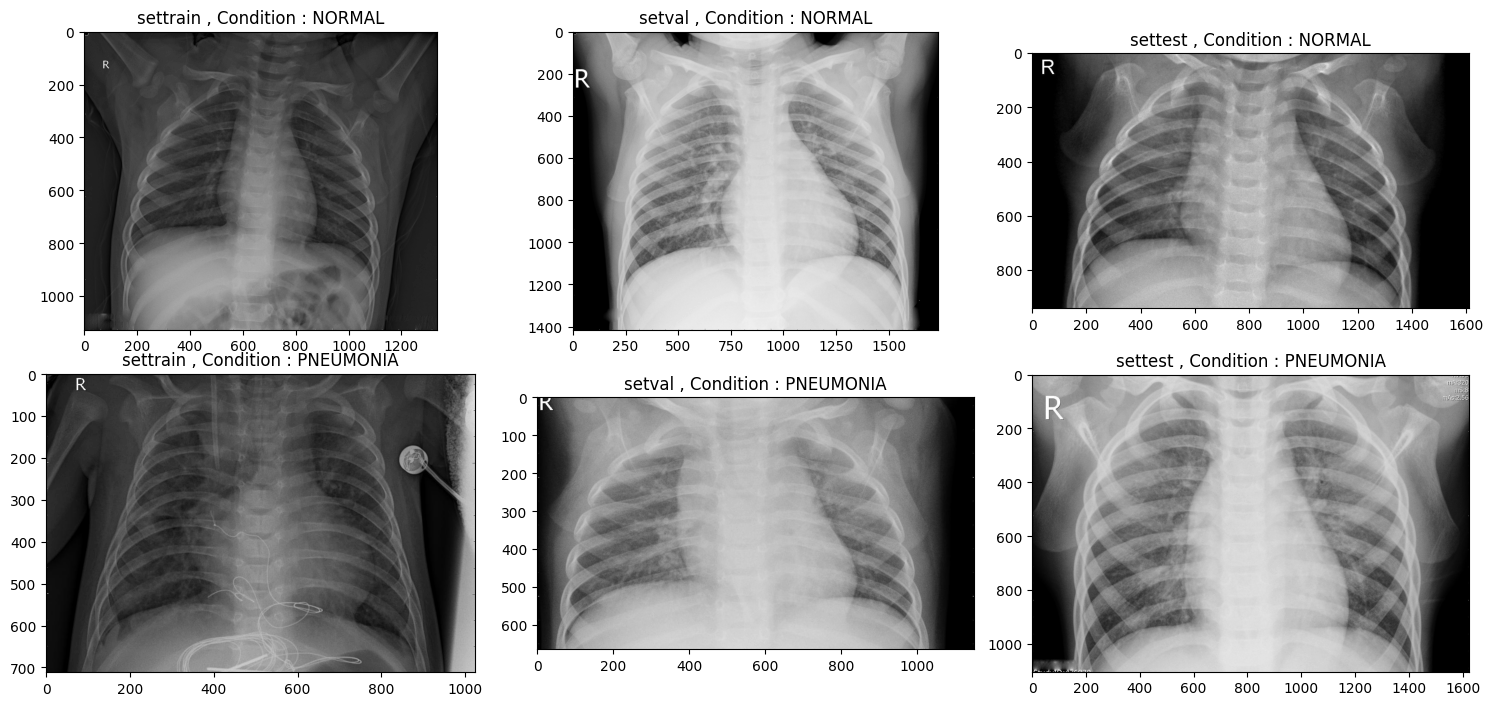

In [34]:
input_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'
fig, ax = plt.subplots(2, 3, figsize=(15, 7))  # Correct usage
ax = ax.ravel()  # Flatten the axes array
plt.tight_layout()
for i ,_set in enumerate(['train' , 'val' , 'test']):
    set_path = input_path + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/' + os.listdir(set_path+'/NORMAL/')[0]),cmap = 'gray' )
    ax[i].set_title('set{} , Condition : NORMAL'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/' + os.listdir(set_path+'/PNEUMONIA/')[0]),cmap = 'gray' )
    ax[i+3].set_title('set{} , Condition : PNEUMONIA'.format(_set))
plt.show()

In [35]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)
    
    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))
    
    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

# **Model Building**

In [38]:
# Charger MobileNetV2 pré-entraîné sans les couches supérieures
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)
# Freeze the layers in the base model
base_model.trainable = False

# Ajouter des couches de classification au modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [39]:
model = Model(inputs=base_model.input, outputs=predictions)

# **Compile and Fitting**

In [40]:
# Compiler le modèle
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 176s 260ms/step - accuracy: 0.8592 - loss: 0.3045 - val_accuracy: 0.7500 - val_loss: 0.3468
Epoch 2/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 197s 252ms/step - accuracy: 0.9360 - loss: 0.1460 - val_accuracy: 0.8750 - val_loss: 0.2540
Epoch 3/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 206s 258ms/step - accuracy: 0.9424 - loss: 0.1399 - val_accuracy: 0.8125 - val_loss: 0.3178
Epoch 4/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 166s 252ms/step - accuracy: 0.9453 - loss: 0.1368 - val_accuracy: 0.8125 - val_loss: 0.3520
Epoch 5/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 203s 254ms/step - accuracy: 0.9535 - loss: 0.1187 - val_accuracy: 0.8125 - val_loss: 0.2419
Epoch 6/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 200s 252ms/step - accuracy: 0.9463 - loss: 0.1281 - val_accuracy: 0.8125 - val_loss: 0.3146
Epoch 7/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 203s 253ms/step - accuracy: 0.9529 - loss: 0.1273 - val_accuracy: 0.8125 - val_loss: 0.5826
Epoch 8/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 164s 250ms/step - accuracy: 0.9476 -

# **Val Loss and Accuracy**

In [47]:
# Évaluer le modèle sur l'ensemble de test
evaluation = model.evaluate(test_generator)
print("Accuracy on test set:", evaluation[1] * 100, "%")

78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.8605 - loss: 0.3449
Accuracy on test set: 86.05769276618958 %


/tmp/ipykernel_34/1804735075.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


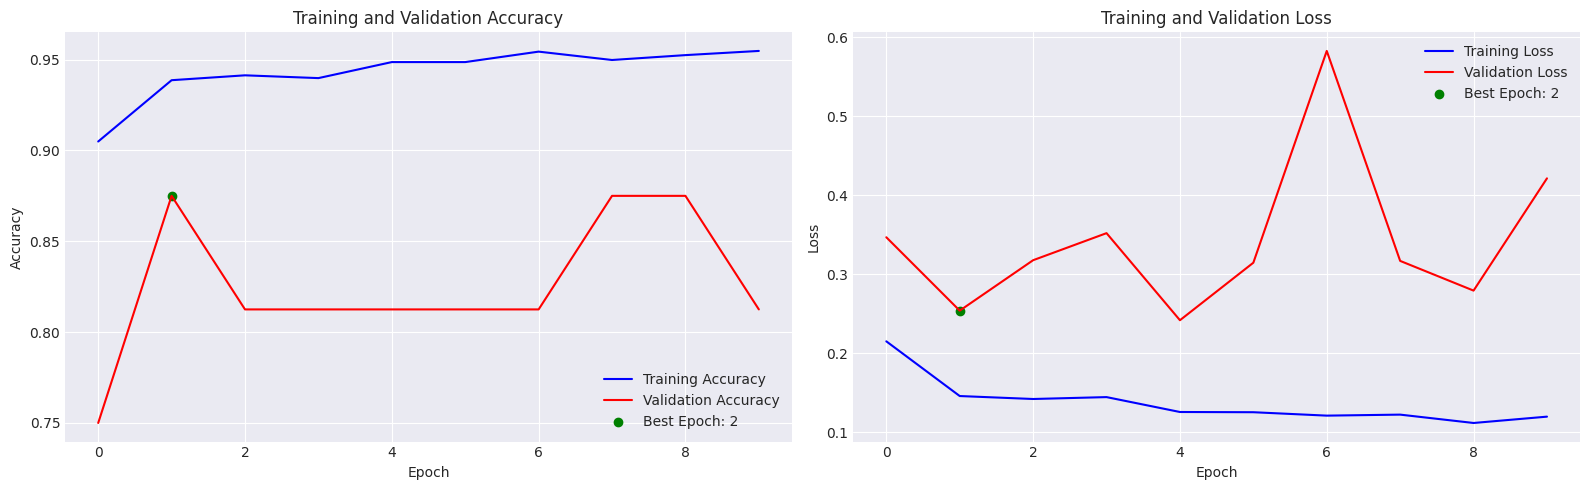

In [49]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# **Model Predictions**

Testing Images:
Found 624 files belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 755ms/step


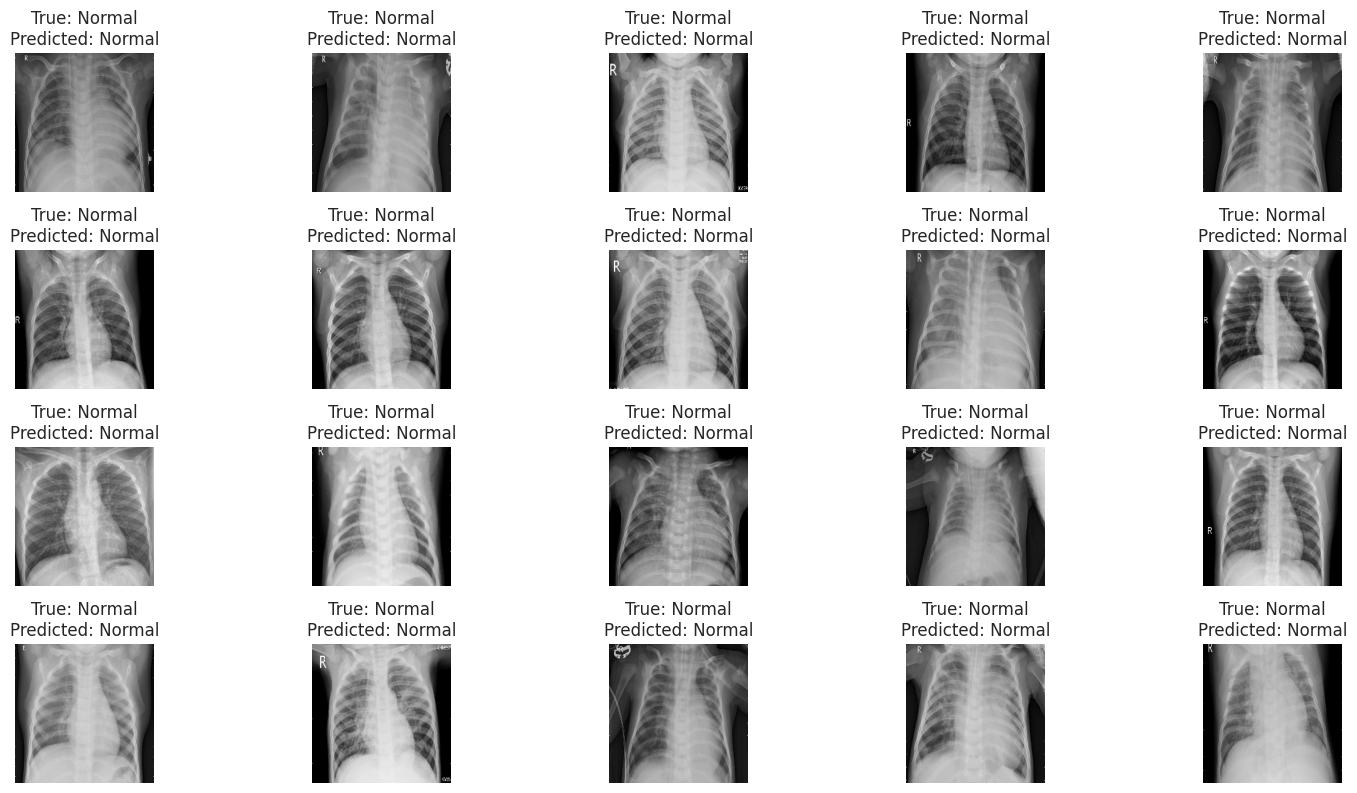

In [70]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the image size
IMAGE_SIZE = (224, 224)  # Adjust this if your model expects a different image size

# Load the model
image_files = os.listdir(directory_path)[:5]
# Load class labels
class_labels = ['Normal', 'Pneumonia']

# Function to plot images with predictions
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    # Generate predictions for a set number of images
    predictions = model.predict(dataset)

    # Shuffle the dataset
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))

    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # Convert tensor to NumPy array
        images = images.numpy()

        # Iterate over each image in the batch
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # Check if total images exceed desired count
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]

                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on testing data
print('Testing Images:')
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32  # Set the batch size to match the model's expected batch dimension
)

plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


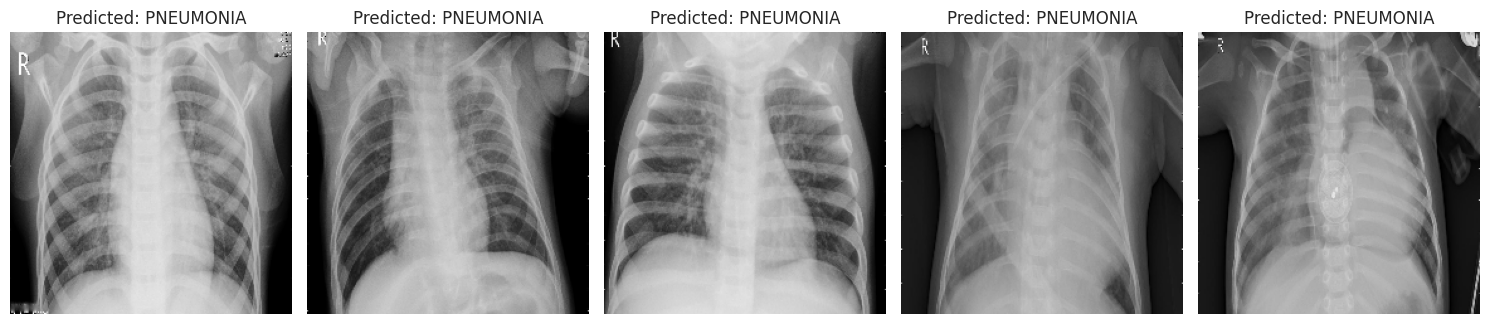

In [62]:
# Path to the directory containing the images
directory_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

# Select N image files from the directory
image_files = os.listdir(directory_path)[:5]

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

# Load and preprocess each image, make predictions, and display them using a loop
for i, image_file in enumerate(image_files):
  img_path = os.path.join(directory_path, image_file)
  # Load the image using OpenCV
  img = cv2.imread(img_path)
  # Resize the image to (256, 256)
  expected_shape = (224, 224)  # Replace with the actual expected shape
  img = cv2.resize(img, expected_shape) 

  # Normalize pixel values
  img_array = img.astype(np.float32) / 255.0  

  # Expand the dimensions to match the input shape expected by the model
  img_array = np.expand_dims(img_array, axis=0)

  # Make predictions
  predictions = model.predict(img_array)
  actual_prediction = (predictions > 0.5).astype(int)

  # Display the image with predicted label
  # Convert BGR to RGB for displaying with matplotlib
  axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  axs[i].axis('off')

  # Set title based on prediction (outside if-else block for better readability)
  if actual_prediction[0][0] == 0:
      predicted_label = 'Normal'
  else:
      predicted_label = 'PNEUMONIA'
  axs[i].set_title(f'Predicted: {predicted_label}')

# Adjust layout
plt.tight_layout()
plt.show()